# Vehicle Detection
By Chris Gundling
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

#### Section 1: Import Everything for Pipeline

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

#### Section 2: Define Pipeline Functions (HOG Features, Bin Colors, Color Hist, Sliding Window, Draw Boxes)

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


def bin_spatial2(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
    
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def color_hist2(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial(), color_hist() and extract HOG
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)  
            elif hog_channel == 'MULTIPLE':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    if channel == 0:
                        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                    if channel == 1:
                        feature_image = np.copy(image) 
                    if channel == 2:
                        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)   
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)  
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5), add_more = False, windows_p = None):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-nx_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    if add_more == False:
        window_list = []
    else:
        window_list = windows_p
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))   
        elif hog_channel == 'MULTIPLE':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                if channel == 0:
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
                if channel == 1:
                    feature_image = np.copy(img) 
                if channel == 2:
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)   
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))   
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# HOG Subsampling (Define function that can extract features and make predictions)
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial2(subimg, size=spatial_size)
            hist_features = color_hist2(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

#### Section 3: Visualizing the HOG Features

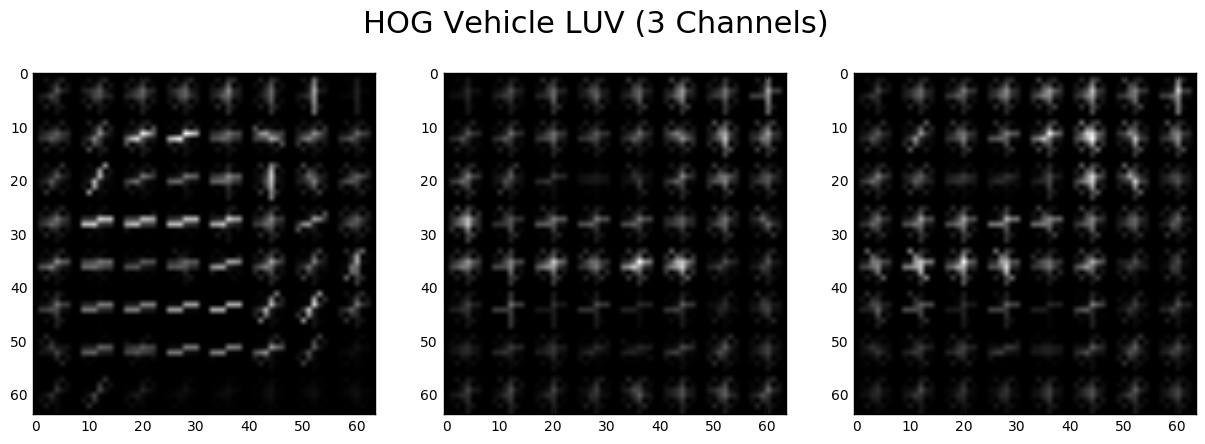

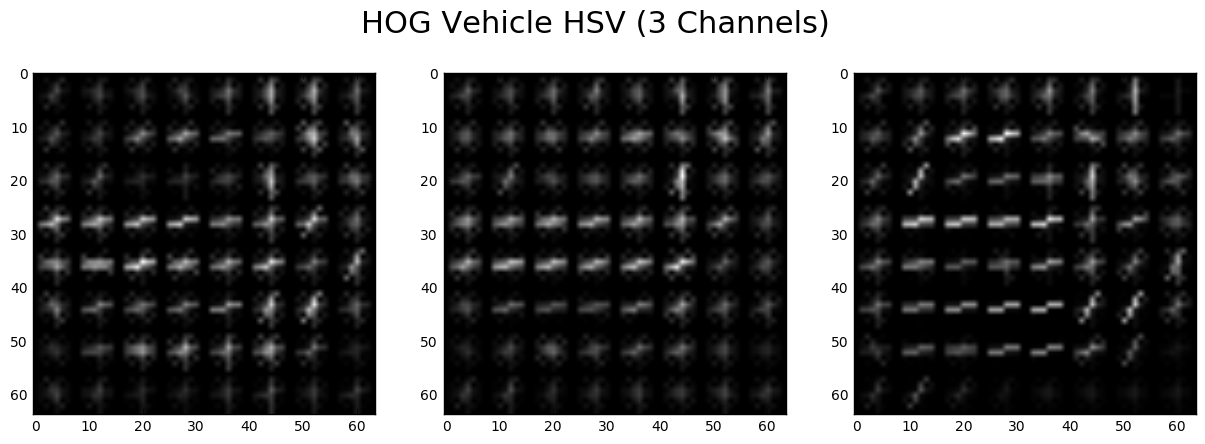

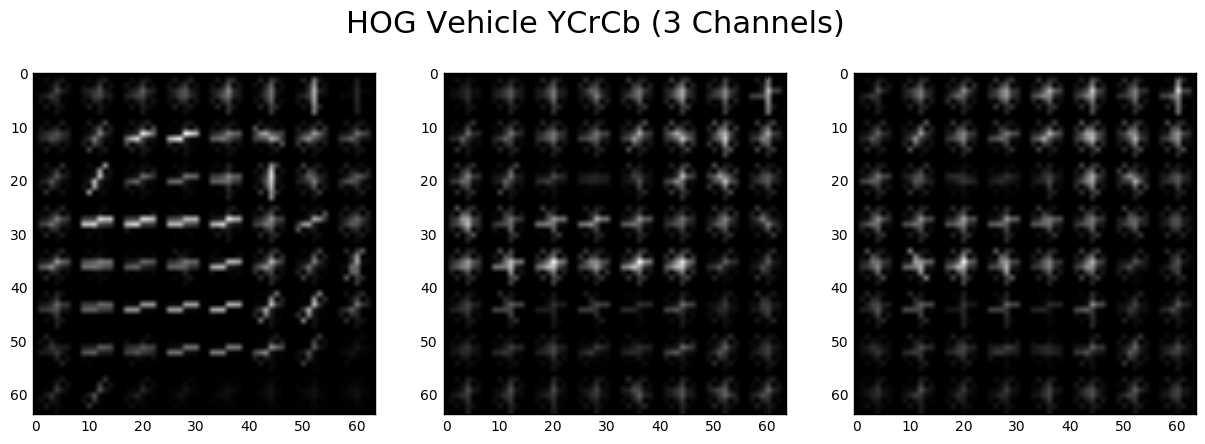

In [3]:
image_non = cv2.imread('non-vehicles/Extras/extra2.png')
image_yes = cv2.imread('vehicles/KITTI_extracted/17.png')
image_non = cv2.cvtColor(image_non, cv2.COLOR_BGR2RGB)
image_yes = cv2.cvtColor(image_yes, cv2.COLOR_BGR2RGB)

### TODO: Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 680] # Min and max in y to search in slide_window()
x_start_stop = [350, None] # Min and max in y to search in slide_window()

img = cv2.cvtColor(image_yes, cv2.COLOR_RGB2LUV)
ex_features, hog_image_LUV0 = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
ex_features, hog_image_LUV1 = get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
ex_features, hog_image_LUV2 = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

img = cv2.cvtColor(image_yes, cv2.COLOR_RGB2HSV)
ex_features, hog_image_HSV0 = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
ex_features, hog_image_HSV1 = get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
ex_features, hog_image_HSV2 = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

img = cv2.cvtColor(image_yes, cv2.COLOR_RGB2YCrCb)
ex_features, hog_image_Y0 = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
ex_features, hog_image_Y1 = get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
ex_features, hog_image_Y2 = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

#plt.title('Non-Vehicle Example')
#plt.imshow(image_non)
#fig = plt.gcf()
#fig.set_size_inches(3, 3)
#plt.show()

#plt.title('Vehicle Example')
#plt.imshow(image_yes)
#fig = plt.gcf()
#fig.set_size_inches(3, 3)
#plt.show()

plt.suptitle('HOG Vehicle LUV (3 Channels)', fontsize=22)
plt.subplot(1,3,1)
plt.imshow(hog_image_LUV0, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(hog_image_LUV1, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(hog_image_LUV2, cmap='gray')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

plt.suptitle('HOG Vehicle HSV (3 Channels)', fontsize=22)
plt.subplot(1,3,1)
plt.imshow(hog_image_HSV0, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(hog_image_HSV1, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(hog_image_HSV2, cmap='gray')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

plt.suptitle('HOG Vehicle YCrCb (3 Channels)', fontsize=22)
plt.subplot(1,3,1)
plt.imshow(hog_image_Y0, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(hog_image_Y1, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(hog_image_Y2, cmap='gray')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

#### Section 4: Train the SVM Clasifier

In [44]:
# Read in car and non-car images
images_no = glob.glob('non-vehicles/Extras/extra*.png')
images_no2 = glob.glob('non-vehicles/GTI/image*.png')

images_yes = glob.glob('vehicles/KITTI_extracted/*.png')
images_yes2 = glob.glob('vehicles/GTI_Right/image*.png')
images_yes3 = glob.glob('vehicles/GTI_Left/image*.png')
images_yes4 = glob.glob('vehicles/GTI_MiddleClose/image*.png')
images_yes5 = glob.glob('vehicles/GTI_Far/image*.png')

cars = []
notcars = []
for image in images_no:
    #if 'image' in image or 'extra' in image:
    notcars.append(image)
    
for image in images_no2:
    #if 'image' in image or 'extra' in image:
    notcars.append(image)

for image in images_yes:
    cars.append(image)

for image in images_yes2:
    cars.append(image)

for image in images_yes3:
    cars.append(image)

for image in images_yes4:
    cars.append(image)
    
for image in images_yes5:
    cars.append(image)

color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'MULTIPLE' # Can be 0, 1, 2, or "ALL", or "MULTIPLE"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 680] # Min and max in y to search in slide_window()
x_start_stop = [350, None] # Min and max in y to search in slide_window()

def train_test_svc(cars, notcars):
    ### TODO: Tweak these parameters and see how the results change.
    color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'MULTIPLE' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    t=time.time()
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...')

    print(len(car_features),len(notcar_features))
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    X_new = scaled_X[0:7016]
    X_new = np.vstack((X_new,scaled_X[8793:15984]))

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    y_new = y[0:7016]
    y_new = np.hstack((y_new,y[8793:15984]))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    
    X_train, X_test, y_train, y_test = train_test_split(
    X_new, y_new, test_size=0.0, random_state=rand_state)
    
    print(len(scaled_X),len(y))
    X_test = scaled_X[7016:8793] 
    X_test = np.vstack((X_test, scaled_X[15984:]))
    y_test = y[7016:8793]
    y_test = np.hstack((y_test, y[15984:]))
    
    print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    t=time.time()
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to Test SVC...') # Time to test on 3552 images
    return svc, X_scaler

# Run
svc, X_scaler = train_test_svc(cars, notcars)

# De-allocate images
images_no = []
images_no2 = []
images_yes = []
images_yes2 = []
images_yes3 = []
images_yes4 = []
images_yes5 = []
cars = []
notcars = []

112.55 Seconds to extract features...
8792 8968
17760 17760
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
23.42 Seconds to train SVC...
Test Accuracy of SVC =  0.953
0.15 Seconds to Test SVC...


#### Section 5: Test Out Sliding Windows

24 40 60 36 21 18


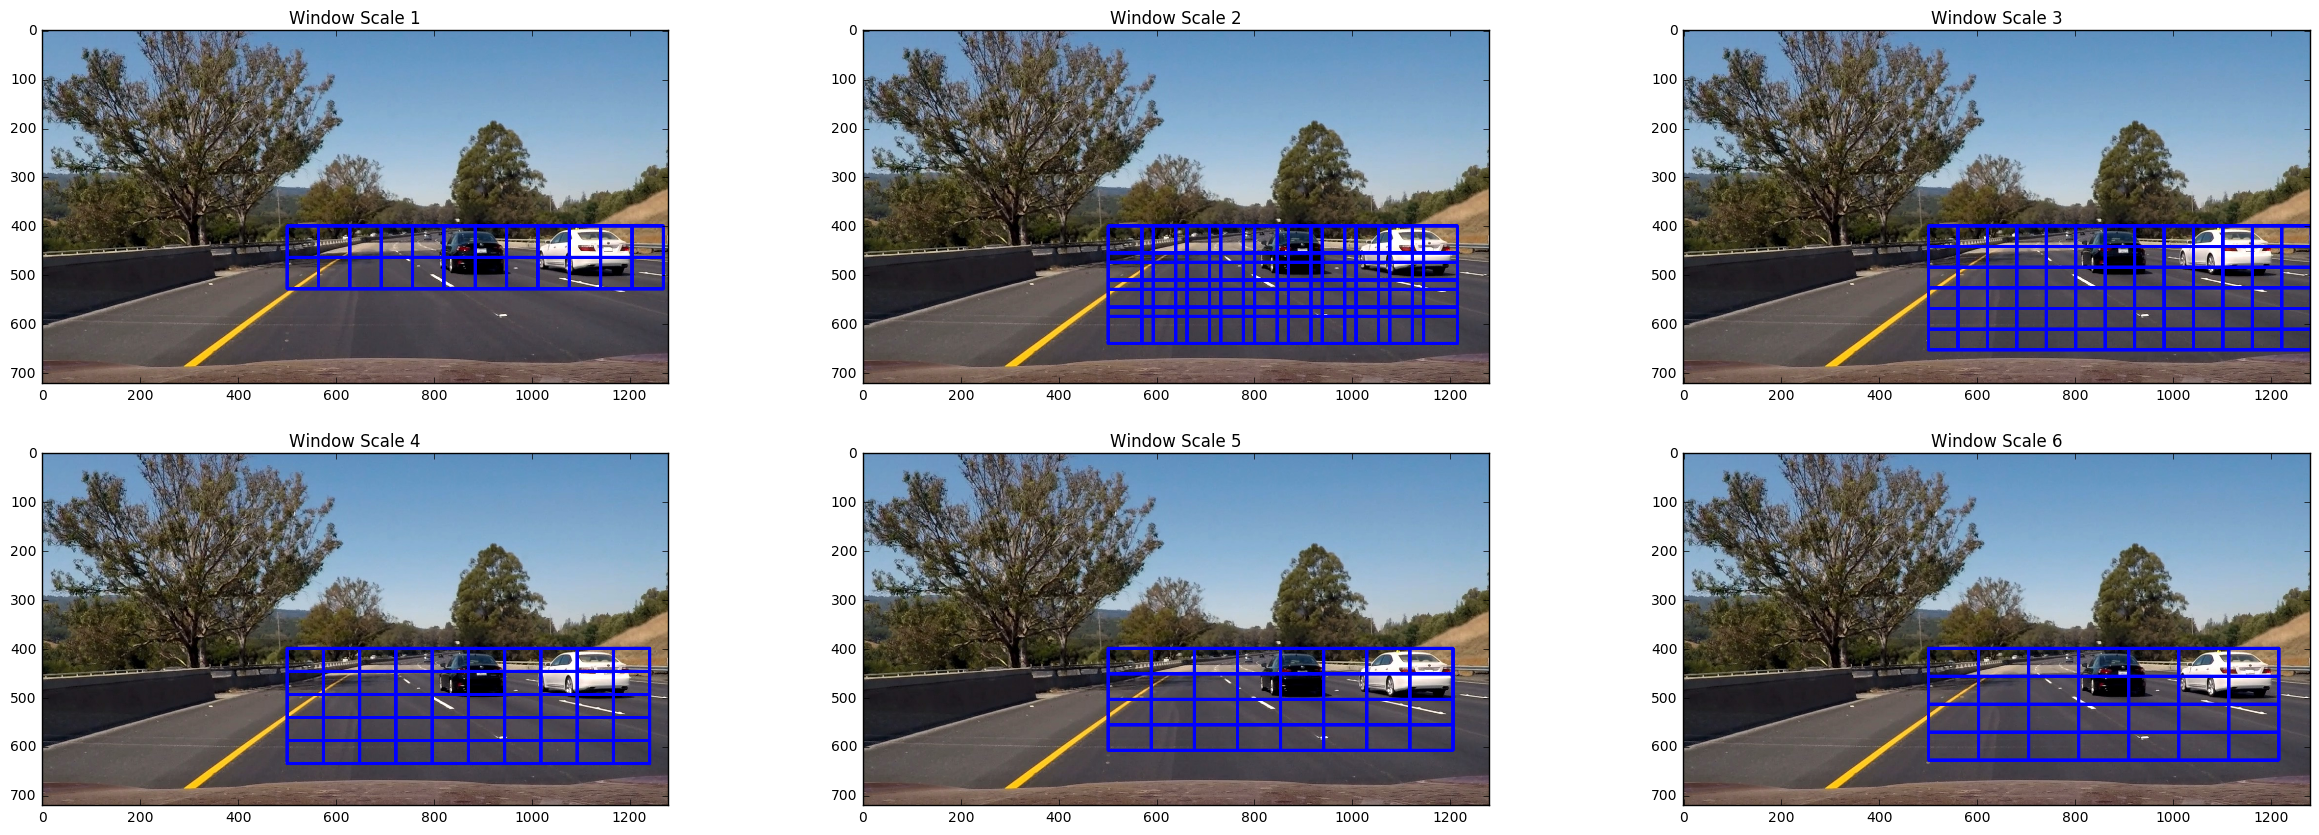

In [55]:
#image = mpimg.imread('CarND-Vehicle-Detection-master/test_images/test1.jpg') 
image = cv2.imread('CarND-Vehicle-Detection-master/test_images/test6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

y_start_stop = [400, 560] # Min and max in y to search in slide_window()
x_start_stop = [500, None] # Min and max in y to search in slide_window()

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.0, 0.0), add_more=False, windows_p=None)

y_start_stop = [400, 680] # Min and max in y to search in slide_window()
x_start_stop = [500, None] # Min and max in y to search in slide_window()

windows2 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(92, 74), xy_overlap=(0.25, 0.25), add_more=False, windows_p=None)

windows3 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(120, 84), xy_overlap=(0.5, 0.5), add_more=False, windows_p=None)

windows4 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(148, 94), xy_overlap=(0.5, 0.5), add_more=False, windows_p=None)

windows5 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(176, 104), xy_overlap=(0.5, 0.5), add_more=False, windows_p=None)

windows6 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(204, 114), xy_overlap=(0.5, 0.5), add_more=False, windows_p=None)

#for i in range(1,6):
#    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
#                    xy_window=(64+28*i, 64+10*i), xy_overlap=(0.5, 0.5), add_more=True, windows_p=windows)
                       
window_img  = draw_boxes(image, windows, color=(0, 0, 255), thick=6) 
window_img2 = draw_boxes(image, windows2, color=(0, 0, 255), thick=6) 
window_img3 = draw_boxes(image, windows3, color=(0, 0, 255), thick=6) 
window_img4 = draw_boxes(image, windows4, color=(0, 0, 255), thick=6) 
window_img5 = draw_boxes(image, windows5, color=(0, 0, 255), thick=6) 
window_img6 = draw_boxes(image, windows6, color=(0, 0, 255), thick=6) 
print(len(windows),len(windows2),len(windows3),len(windows4),len(windows5),len(windows6))

plt.subplot(2,3,1)
plt.title('Window Scale 1')
plt.imshow(window_img)
plt.subplot(2,3,2)
plt.title('Window Scale 2')
plt.imshow(window_img2)
plt.subplot(2,3,3)
plt.title('Window Scale 3')
plt.imshow(window_img3)
plt.subplot(2,3,4)
plt.title('Window Scale 4')
plt.imshow(window_img4)
plt.subplot(2,3,5)
plt.title('Window Scale 5')
plt.imshow(window_img5)
plt.subplot(2,3,6)
plt.title('Window Scale 6')
plt.imshow(window_img6)

fig = plt.gcf()
fig.set_size_inches(30, 10)
plt.show()

#### Section 6: Test the Classifier on Single Images

1.06 Seconds for bbox detection...


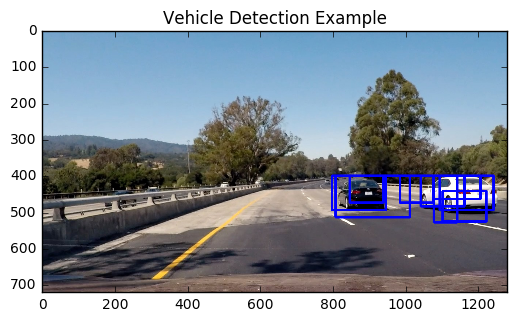

In [70]:
# Check the prediction time for a single sample
t=time.time()

image = cv2.imread('CarND-Vehicle-Detection-master/test_images/test4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

y_start_stop = [400, 560] # Min and max in y to search in slide_window()
x_start_stop = [500, None] # Min and max in y to search in slide_window()

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.0, 0.0), add_more=False, windows_p=None)

y_start_stop = [400, 680] # Min and max in y to search in slide_window()
x_start_stop = [500, None] # Min and max in y to search in slide_window()

for i in range(1,6):
    if i == 1:
        xy_overlap=(0.25, 0.25)
    if i > 1:
        xy_overlap=(0.5, 0.5)
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(64+28*i, 64+10*i), xy_overlap=xy_overlap, add_more=True, windows_p=windows) 

color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 'MULTIPLE' # Can be 0, 1, 2, or "ALL"

# Option 2 For Video Processing
#y_start_stop = [400, 680] # Min and max in y to search in slide_window()
#x_start_stop = [None, None] # Min and max in y to search in slide_window()
#scale = 1.5
#window_img = find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

t2 = time.time()
print(round(t2-t, 2), 'Seconds for bbox detection...')
plt.title('Vehicle Detection Example')
plt.imshow(window_img)

#### Section 7: Heat Map on the Final Bounding Boxes

0.05 Seconds for heat map detection...


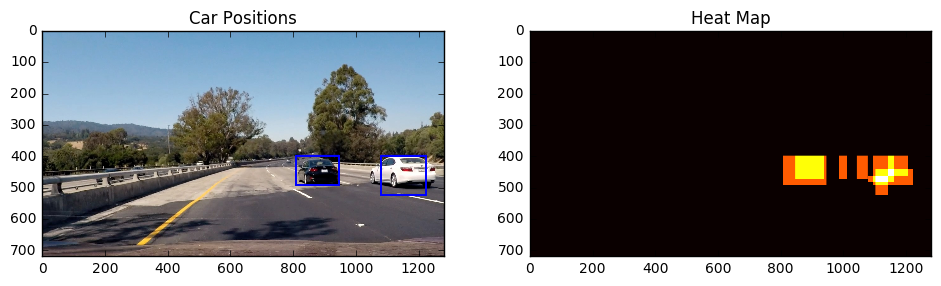

In [72]:
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above

# Check the prediction time for a single heat map
t=time.time()

box_list = hot_windows #pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = cv2.imread('CarND-Vehicle-Detection-master/test_images/test4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if (bbox[1][0] - bbox[0][0]) > 60 and (bbox[1][1] - bbox[0][1]) > 60:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_labeled_bboxes_vid(img, labels):
    global store
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        if labels[1] == 2:
            store += 1
            if car_number == 1:  
                bbox_store1.append(bbox)
            if car_number == 2:
                bbox_store2.append(bbox)
    if len(bbox_store1) > 5:
        bbox_avg1 = 0
        bbox_avg2 = 0
        bbox_avg3 = 0
        bbox_avg4 = 0
        for i in range(5):
            bbox_avg1 += bbox_store1[store-1+i][0]
            bbox_avg2 += bbox_store1[store-1+i][1]
            bbox_avg3 += bbox_store1[store-1+i][2]
            bbox_avg4 += bbox_store1[store-1+i][3]
        bbox = ((bbox_avg1,bbox_avg2),(bbox_avg3,bbox_avg4)) 
        # Draw the box on the image
    cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

t2 = time.time()
print(round(t2-t, 2), 'Seconds for heat map detection...')
#draw_img = cv2.cvtColor(draw_img, cv2.COLOR_HSV2RGB)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
fig.set_size_inches(10, 5)
plt.show()

#### Section 8: Process Video Images

In [60]:
# Pipeline function for video processing
def process_image(img):
    global bbox_store1, bbox_store2, count, heat_store
    image = img #cv2.imread(img)
    count += 1
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    draw_image = np.copy(image)

    #windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
    #                xy_window=(64, 64), xy_overlap=(0.5, 0.5), add_more=False, windows_p=None)

    ##for i in range(1,6):
    #    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
    #              xy_window=(64+28*i, 64+10*i), xy_overlap=(0.5, 0.5), add_more=True, windows_p=windows)
    
    y_start_stop = [380, 560] # Min and max in y to search in slide_window() 
    x_start_stop = [500, None] # Min and max in y to search in slide_window() 

    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.0, 0.0), add_more=False, windows_p=None)

    y_start_stop = [380, 680] # Min and max in y to search in slide_window()
    x_start_stop = [500, None] # Min and max in y to search in slide_window()

    for i in range(1,6):
        if i == 1:
            xy_overlap=(0.25, 0.25)
        if i > 1:
            xy_overlap=(0.5, 0.5)
            
        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(64+28*i, 64+10*i), xy_overlap=xy_overlap, add_more=True, windows_p=windows)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
    
    # Heat map thresholding
    box_list = hot_windows #pickle.load( open( "bbox_pickle.p", "rb" ))
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    heat_store.append(heat)
    smooth_heat = 10
    if count > smooth_heat:
        for i in range(10):
            heat = heat + heat_store[count-(smooth_heat+1-i)] 
            
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,15)
    #print(np.max(heat))

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    #draw_img = cv2.cvtColor(draw_img, cv2.COLOR_HSV2RGB)
    return draw_img

#### Section 9: Video Result

In [53]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

def save_image(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.imsave('CarND-Vehicle-Detection-master/test_images/test1.jpg',img)
    return img

bbox_store1 = []
bbox_store2 = []
heat_store = []
count = 0
store = 0

final_output = 'P5_final.mp4'
clip1 = VideoFileClip("CarND-Vehicle-Detection-master/project_video.mp4")#.subclip(30,50)
final_clip = clip1.fl_image(process_image)
#white_clip = clip1.fl_image(save_image)
#plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
%time final_clip.write_videofile(final_output, audio=False)

[MoviePy] >>>> Building video P5_final.mp4
[MoviePy] Writing video P5_final.mp4


100%|█████████▉| 1260/1261 [15:08<00:00,  1.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P5_final.mp4 

CPU times: user 14min 39s, sys: 34.3 s, total: 15min 14s
Wall time: 15min 10s
